In [1]:
# This is a Python 3 script

In [9]:
# Format code for fortran code: FORMAT(I4,F10.3,F10.3)
def ConstructInputASURV(fitting_table, line1, line2, outdir, obj=None):
    from astropy.io import ascii
    import numpy as np

    data = ascii.read(fitting_table)
    
    # get line fitting results of a single object if specified
    if obj != None:
        data = data[data['Object'] == obj]
    
    
    # Restrict to only select the 1-D spectra
    data = data[data['Pixel_No.'] == 'c']
    
    data1 = data[data['Line'] == line1]
    data2 = data[data['Line'] == line2]
    
    # make sure the objects have both PACS and SPIRE data
    data1_filter = np.zeros_like(data1['Validity'].data, dtype='bool')
    for i in range(len(data1)):
        if data1['Object'][i] in data2['Object'].data:
            data1_filter[i] = True

    data2_filter = np.zeros_like(data2['Validity'].data, dtype='bool')
    for i in range(len(data2)):
        if data2['Object'][i] in data1['Object'].data:
            data2_filter[i] = True
    
    data1 = data1[data1_filter]
    data2 = data2[data2_filter]
    
    # replace the non-detection to upper limit
    def FindUpperLimit(table):
        upperlimit_flag = np.empty_like(table['Str(W/cm2)'].data, dtype=int)
        linestr = np.empty_like(table['Str(W/cm2)'].data, dtype=float)
        linestr_unc = np.empty_like(table['Str(W/cm2)'].data, dtype=float)
        
        for i in range(len(table)):
            # for line fluxes with SNR < 3 or not able to fit properly
            if (table['Validity'][i].astype('float') == '0') or (table['SNR'][i].astype('float') < 3.0):
                upperlimit_flag[i] = -1
                linestr[i] = table['Noise(W/cm2/um)'][i].astype('float')*table['FWHM(um)'][i].astype('float')*1.064*3
                linestr_unc[i] = -1
            else:
                upperlimit_flag[i] = 0
                linestr[i] = table['Str(W/cm2)'][i].astype('float')
                linestr_unc[i] = table['Sig_str(W/cm2)'][i].astype('float')
            
        # convert the flux unit from W/cm2 to W/m2
        linestr = linestr*1e4
        linestr_unc[linestr_unc != -1] = linestr_unc[linestr_unc != -1]*1e4
        
        return upperlimit_flag, linestr, linestr_unc

    ulf1, linestr1, linestr_unc1 = FindUpperLimit(data1)
    ulf2, linestr2, linestr_unc2 = FindUpperLimit(data2)
    
    # check size
    if len(linestr1) != len(linestr2):
        print('The sizes of two arrays are inconsistent.')
        return None
    
#     For bivariate data:

#     3 : Both Independent and Dependent Variables are Lower Limits
#     2 : Only independent Variable is a Lower Limit
#     1 : Only Dependent Variable is a Lower Limit
#     0 : Detected Point
#     -1 : Only Dependent Variable is an Upper Limit
#     -2 : Only Independent Variable is an Upper Limit
#     -3 : Both Independent and Dependent Variables are Upper Limits

    # Define data1 as the independent variable, and data2 as the dependent variable.
    ulf1 = ulf1*2
    ulf = ulf1+ulf2
    
    # writing out
    foo = open(outdir+'co.dat', 'w')
#     foo.write('# '+line1+' and '+line2+'\n')
#     foo.write('# flux in 10^-18 W/m2 unit. \n')
    for i in range(len(linestr1)):
        foo.write('{:>4d}{:>10.3f}{:>10.3f} \n'.format(ulf[i], linestr1[i]*1e18, linestr2[i]*1e18))
    foo.close()
    
    # if no detection found, throw a flag
    flag = True
    if not 0 in ulf:
        flag = False
    return flag

In [10]:
def RunandParseASURV(code_dir, outdir):
    import os
    import subprocess
    import sys
    
    ON_POSIX = 'posix' in sys.builtin_module_names
    # claer out previous output to prevent seg fault
    if os.path.exists(code_dir+'co.out'):
        os.remove(code_dir+'co.out')

#     p = subprocess.call([code_dir+'asurv_code'])
    p = subprocess.Popen([code_dir+'asurv_code_static'], stdout=subprocess.PIPE, 
                         stderr=subprocess.PIPE, bufsize=1, close_fds=ON_POSIX)
#     p.communicate()
    print(p.stdout.readlines()[-1])
    print(p.stderr.readlines())
    
    out = open(code_dir+'co.out', 'r').read().splitlines()

    # [print(line) for line in out]

    # find the result about generalized Kendall's Tau, and Spearman's Rho
    for line in out:
        if 'Z-VALUE' in line:
            tau_i = out.index(line)
        if 'SPEARMANS RHO =' in line:
            spear_rho = out.index(line)

    kendall = (float(out[tau_i].split('=')[-1].strip()), float(out[tau_i+1].split('=')[-1].strip()))
    spearman = (float(out[spear_rho].split('=')[-1].strip()), float(out[spear_rho+1].split(' ')[16]))
    line1, line2 = out[8].split('AND')[0].strip(), out[8].split('AND')[1].strip()
#     print(kendall, spearman)
#     os.rename(code_dir+'co.out', outdir+line1+'_'+line2+'.out')
#     os.remove(code_dir+'co.out')

    return kendall, spearman


In [51]:
# fitting_table = '/Volumes/SD-Mac/CDF_archive_v2_lines.txt'
fitting_table = '/Users/yaolun/data/CDF_archive_v2/CDF_archive_v2_lines.txt'
line1 = 'CO47-46'
line2 = 'CO4-3'
code_dir = '/Users/yaolun/astro_tools/'
outdir = '/Users/yaolun/astro_tools/'
ConstructInputASURV(fitting_table, line1, line2, outdir)
k, s = RunandParseASURV(code_dir, outdir)
print(k,s)

b'NO DETECTIONS: PROGRAM IS TERMINATED\n'
[b'Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG\n']


UnboundLocalError: local variable 'spear_rho' referenced before assignment

In [63]:
import itertools
from astropy.io import ascii
import numpy as np

# fitting_table = '/Volumes/SD-Mac/CDF_archive_v2_lines.txt'
fitting_table = '/Users/yaolun/data/CDF_archive_v2/CDF_archive_v2_lines.txt'
code_dir = '/Users/yaolun/astro_tools/'
outdir = '/Users/yaolun/astro_tools/'
data = ascii.read(fitting_table)['Line'].data
co_list = np.sort(list(set(list(filter(lambda k: k.startswith('CO'), data)))))

co_list = co_list

# print(list(itertools.combinations(co_list, 2)))

co_pair_list = list(itertools.combinations_with_replacement(co_list, 2))
print(len(co_pair_list))

foo = open(outdir+'co_correlation.txt', 'w')
foo.write('{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}{:<10s}\n'.format('Line1','Line2','Ken.z','Ken.prob','Spr.rho','Spr.prob'))

for pair in co_pair_list:
    line1 = pair[0]
    line2 = pair[1]
    
#     print(line1, line2)
    
    flag = ConstructInputASURV(fitting_table, line1, line2, outdir)
    if flag:
        k, s = RunandParseASURV(code_dir, outdir)
#         print(line1+'/'+line2, k, s)
    
        foo.write('{:<10s}{:<10s}{:<10.3f}{:<10.3f}{:<10.3f}{:<10.3f}\n'.format(line1,line2,k[0],k[1],s[0],s[1]))
    else:
        foo.write('{:<10s}{:<10s}{:<10.3f}{:<10.3f}{:<10.3f}{:<10.3f}\n'.format(line1,line2,0,0,0,0))
    
foo.close()

903
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                         

In [ ]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from astropy.io import ascii
data = ascii.read(outdir+'co.dat', names=['ufl', line1, line2])

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(np.log10(data[line1][data['ufl'] == 0]), np.log10(data[line2][data['ufl'] == 0]), 'o',   mec='b', mfc='None',
         markeredgewidth=1)
# upper limit on x-axis
ax.errorbar(np.log10(data[line1][data['ufl'] == -2]), np.log10(data[line2][data['ufl'] == -2]),
             xerr=np.array([0.1]*len(data[line1][data['ufl'] == -2])), xuplims=True, fmt='o',   mec='b', mfc='None',
             markeredgewidth=1, color='b', elinewidth=1)
# # upper limit on y-axis
ax.errorbar(np.log10(data[line1][data['ufl'] == -1]), np.log10(data[line2][data['ufl'] == -1]),
             yerr=np.array([0.1]*len(data[line1][data['ufl'] == -1])), uplims=True, fmt='o',   mec='b', mfc='None',
             markeredgewidth=1, color='b', elinewidth=1)
# upper limit on both x-axis and y-axis
ax.errorbar(np.log10(data[line1][data['ufl'] == -3]), np.log10(data[line2][data['ufl'] == -3]),
             xerr=np.array([0.1]*len(data[line1][data['ufl'] == -3])), 
             yerr=np.array([0.1]*len(data[line1][data['ufl'] == -3])),
             xuplims=True, uplims=True, fmt='o', mec='b', mfc='None',
             markeredgewidth=1, color='b', elinewidth=1)
ax.set_xlabel('CO J=24-23 [log(W m$^{-2}$)]', fontsize=18)
ax.set_ylabel('CO J=30-29 [log(W m$^{-2}$)]', fontsize=18)
ax.tick_params('both',labelsize=16,which='major')


## Use Pandas and Seaborn to visualize the results

In [13]:
name = 'CO41-40'
name.split('CO')[1].split('-')[0]

'41'

In [2]:
%matplotlib inline

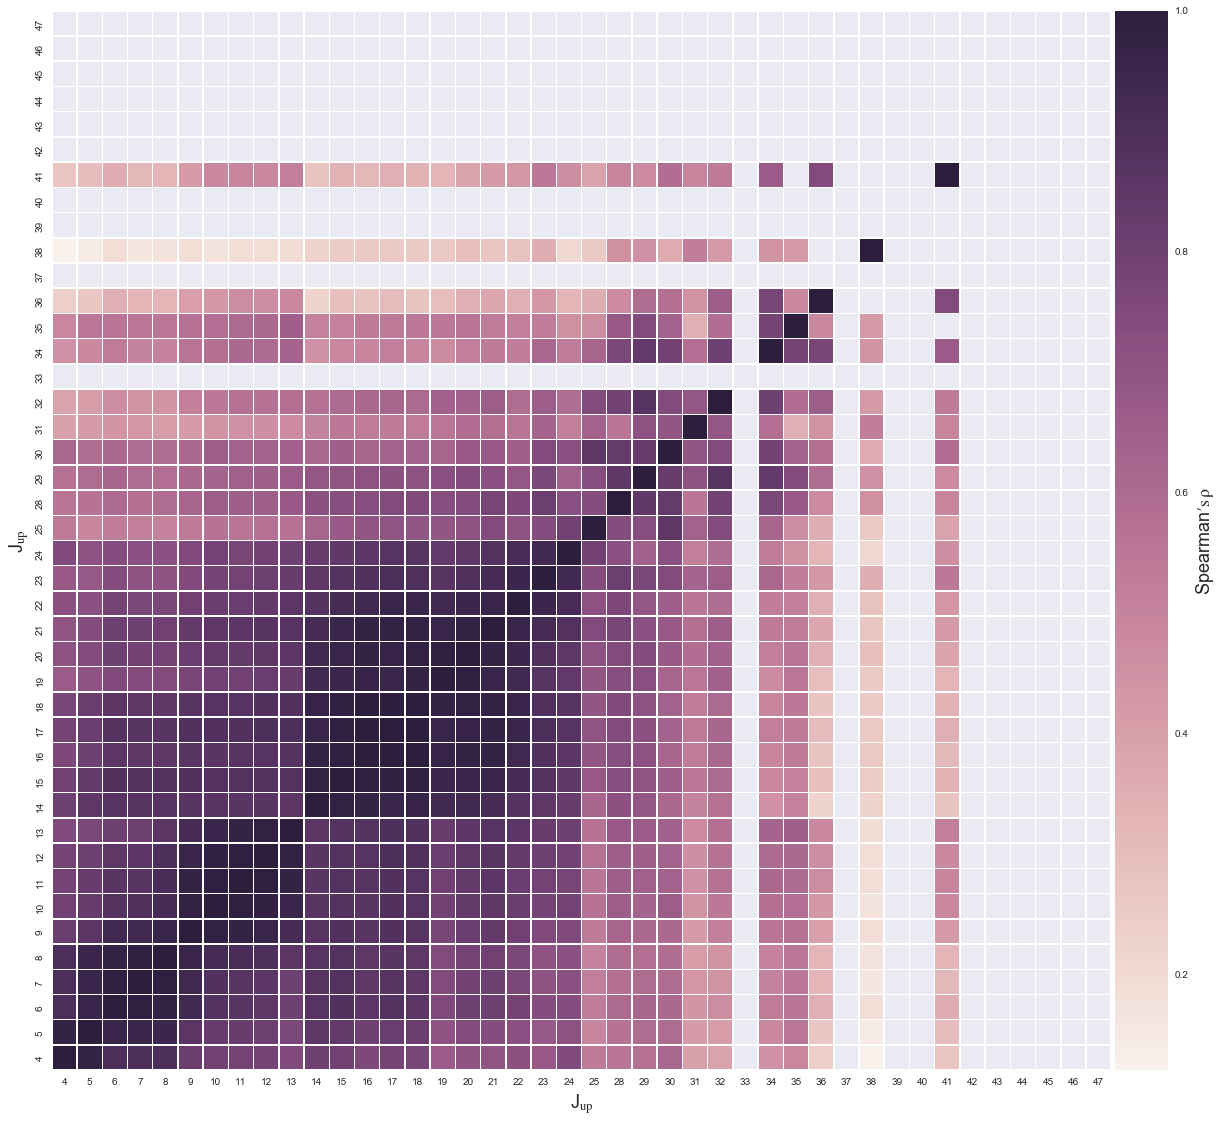

In [31]:
import pandas as pd
import seaborn as sns
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# create data 2d array
data = np.empty((len(co_list), len(co_list)))
j_up = np.sort([int(s.split('CO')[1].split('-')[0]) for s in co_list])

# j_up = j_up[:5]

# read in the result
table = ascii.read(outdir+'co_correlation.txt')
col_name = 'Spr.rho'
# diag_value = 1

for i in range(len(j_up)):
    for j in range(i, len(j_up)):
        selector1 = (table['Line1'] == 'CO'+str(j_up[i])+'-'+str(j_up[i]-1)) & \
                    (table['Line2'] == 'CO'+str(j_up[j])+'-'+str(j_up[j]-1))
        selector2 = (table['Line2'] == 'CO'+str(j_up[i])+'-'+str(j_up[i]-1)) & \
                    (table['Line1'] == 'CO'+str(j_up[j])+'-'+str(j_up[j]-1))
        selector = selector1 + selector2
        
        if not (table['Ken.z']+table['Ken.prob']+table['Spr.rho']+table['Spr.prob'])[selector] == 0:
            data[i,j] = table[col_name][selector]
            data[j,i] = table[col_name][selector]
        else:
            data[i,j] = np.nan
            data[j,i] = np.nan

        

# construct Pandas DataFrame
data = data[::-1,:]
# dataset = pd.DataFrame(data=data[0:5:,-5:], index=j_up[::-1], columns=j_up)
dataset = pd.DataFrame(data=data, index=j_up[::-1], columns=j_up)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

sns.heatmap(dataset, annot=False, linewidths=.5, square=True, ax=ax, cbar_ax=cax)
cax.set_ylabel(r'Spearman$\prime s\,\rho$', fontsize=18)

ax.set_xlabel('J$_{up}$', fontsize=18)
ax.set_ylabel('J$_{up}$', fontsize=18)

fig.savefig('/Users/yaolun/test/co_heatmap'+col_name+'.pdf', format='pdf', dpi=300, bbox_inches='tight')

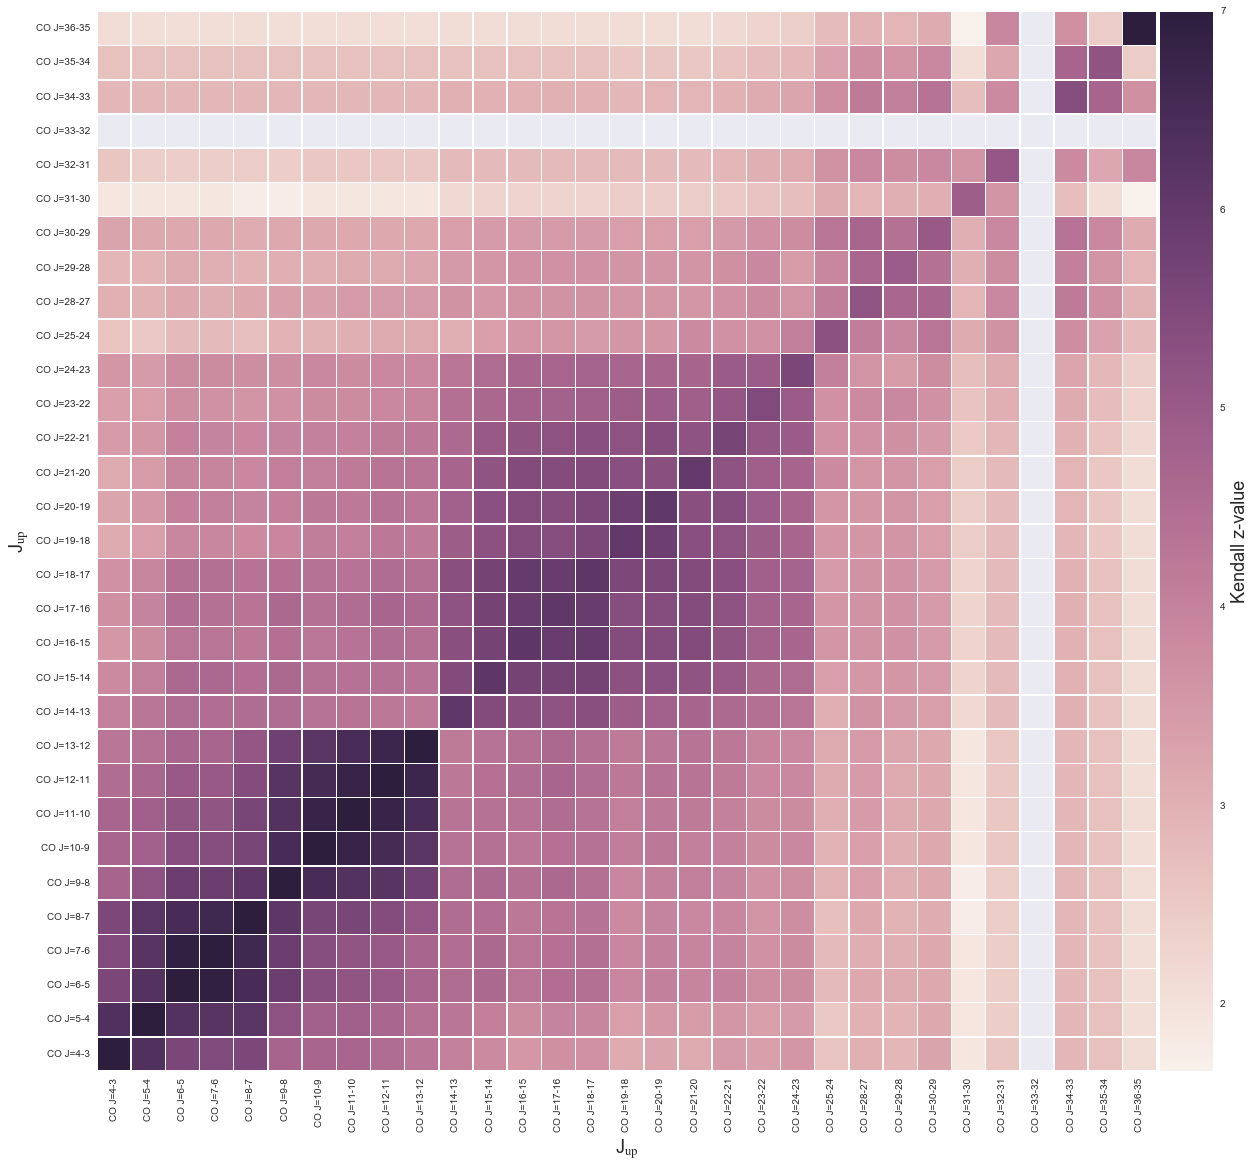

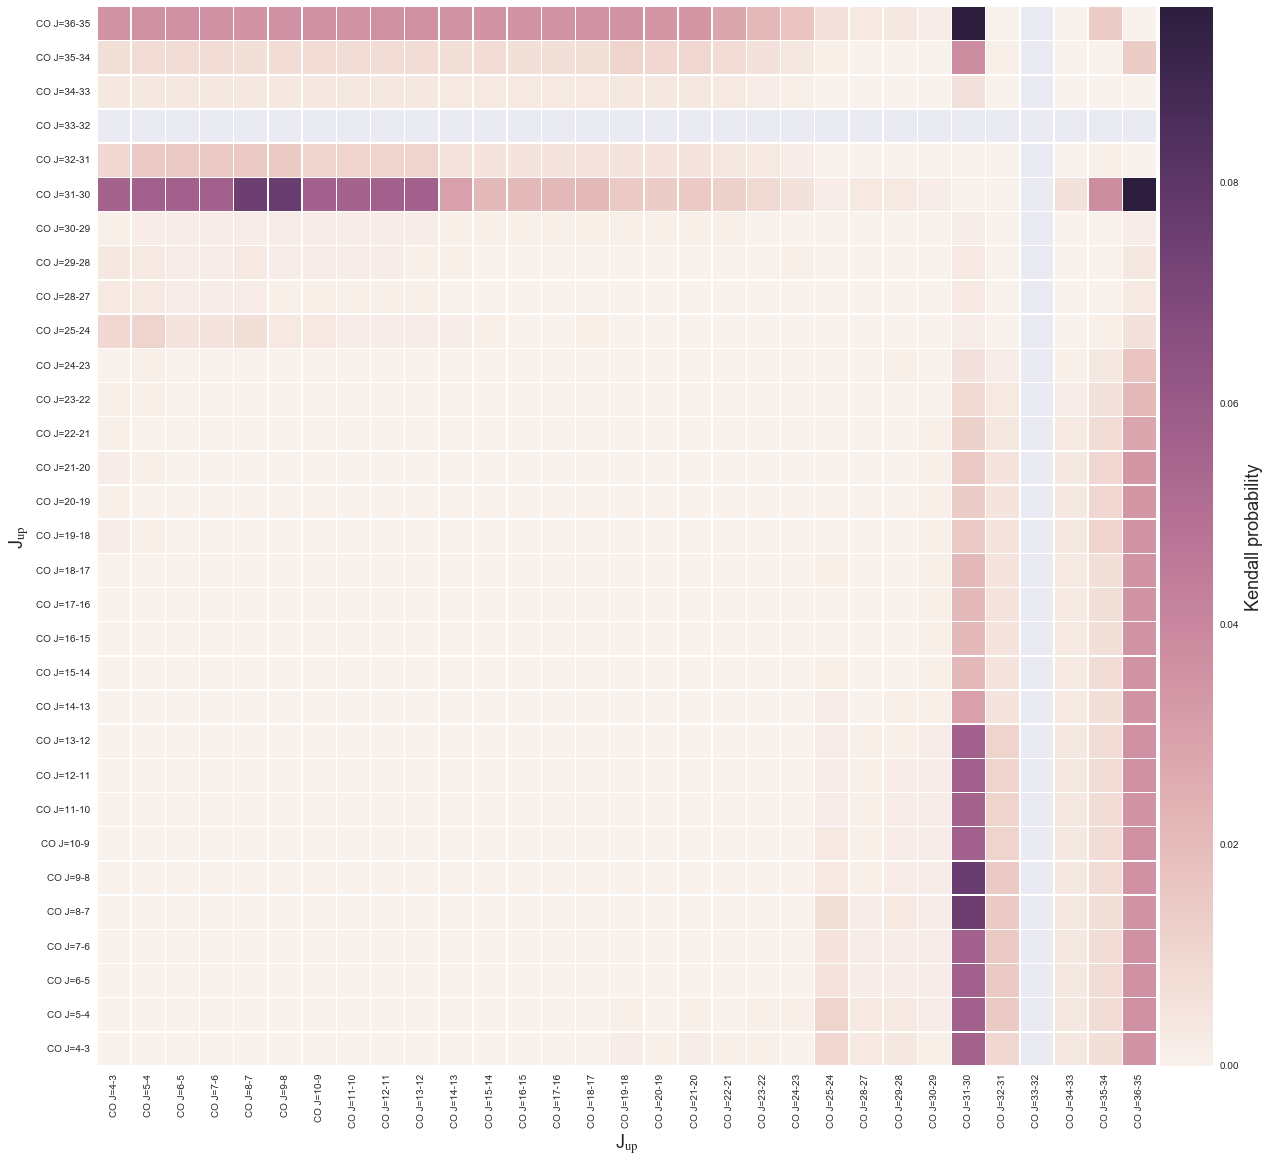

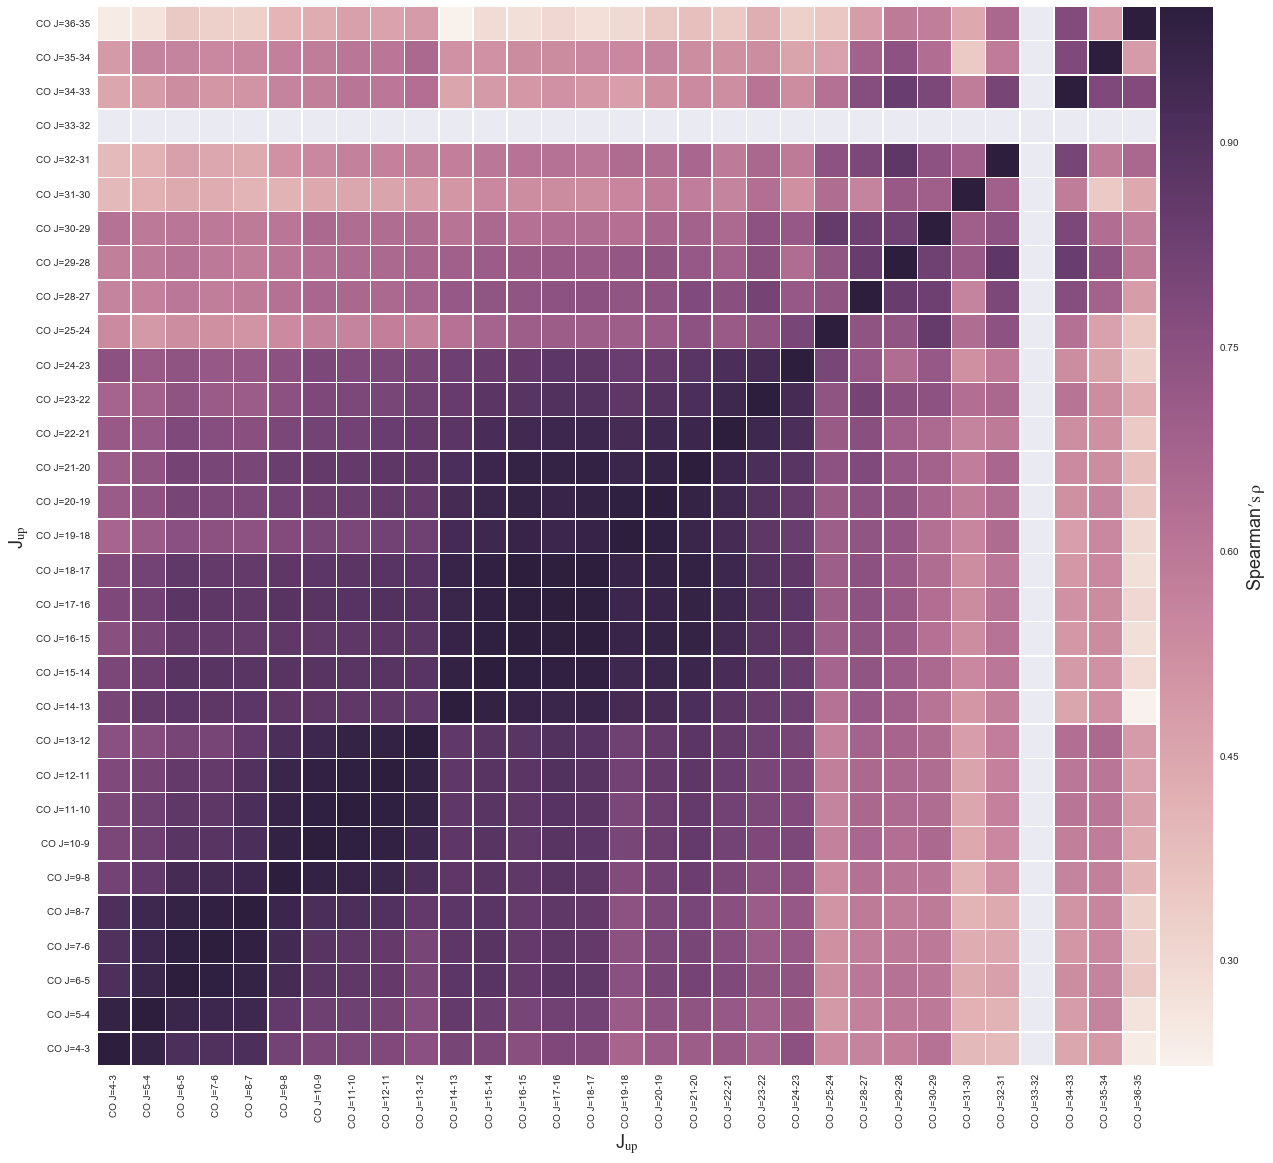

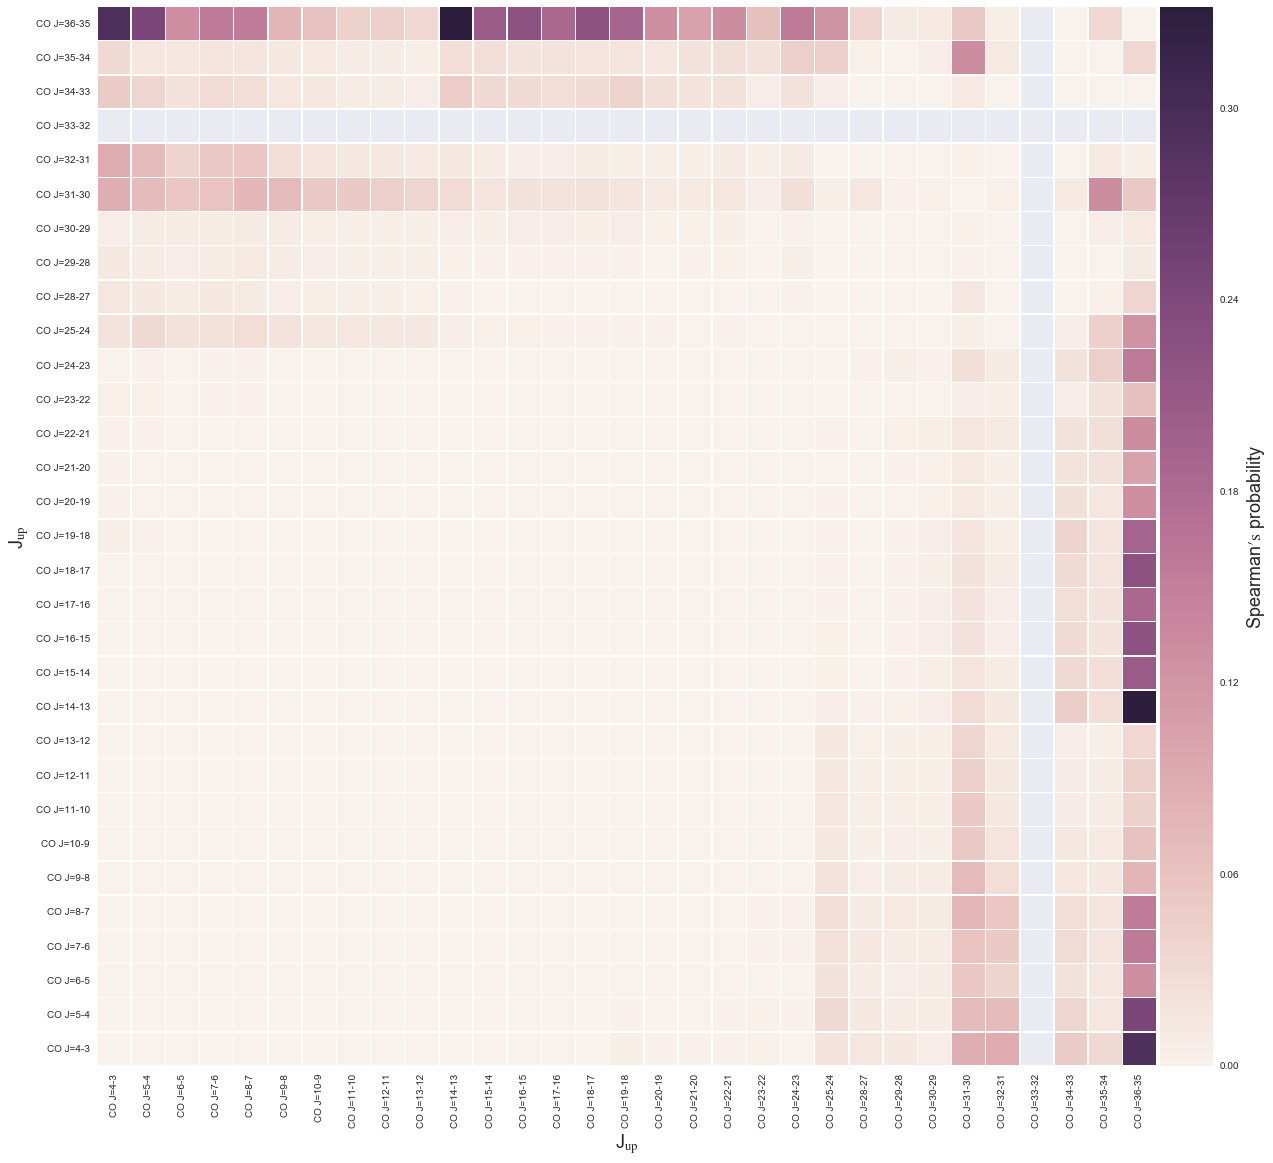

In [34]:
def co_heatmap(col_name, fitting_table, label):
    import pandas as pd
    import seaborn as sns
    import numpy as np
    from astropy.io import ascii
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # create data 2d array
    j_up = np.sort([int(s.split('CO')[1].split('-')[0]) for s in co_list])

    # j_up = j_up[:5]
    j_up = j_up[j_up <= 36]
    data = np.empty((len(j_up), len(j_up)))

    # read in the result
    table = ascii.read(outdir+'co_correlation.txt')

    for i in range(len(j_up)):
        for j in range(i, len(j_up)):
            selector1 = (table['Line1'] == 'CO'+str(j_up[i])+'-'+str(j_up[i]-1)) & \
                        (table['Line2'] == 'CO'+str(j_up[j])+'-'+str(j_up[j]-1))
            selector2 = (table['Line2'] == 'CO'+str(j_up[i])+'-'+str(j_up[i]-1)) & \
                        (table['Line1'] == 'CO'+str(j_up[j])+'-'+str(j_up[j]-1))
            selector = selector1 + selector2

            if not (table['Ken.z']+table['Ken.prob']+table['Spr.rho']+table['Spr.prob'])[selector] == 0:
                data[i,j] = table[col_name][selector]
                data[j,i] = table[col_name][selector]
            else:
                data[i,j] = np.nan
                data[j,i] = np.nan


    # construct Pandas DataFrame
    data = data[::-1,:]
    # dataset = pd.DataFrame(data=data[0:5:,-5:], index=j_up[::-1], columns=j_up)
    line_list = ['CO J='+str(j_up[i])+'-'+str(j_up[i]-1) for i in range(len(j_up))]
    dataset = pd.DataFrame(data=data, index=line_list[::-1], columns=line_list)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    if col_name == 'Ken.z':
        vmax = 7.0
    else:
        vmax = None
    
    sns.heatmap(dataset, annot=False, linewidths=.5, square=True, ax=ax, cbar_ax=cax, vmax=vmax)
    cax.set_ylabel(label, fontsize=18)

    ax.set_xlabel('J$_{up}$', fontsize=18)
    ax.set_ylabel('J$_{up}$', fontsize=18)

    fig.savefig('/Users/yaolun/test/co_heatmap_'+col_name+'.pdf', format='pdf', dpi=300, bbox_inches='tight')

    
col_name = ['Ken.z','Ken.prob','Spr.rho','Spr.prob']
diag_value = [np.nan,0,1,0]
labels = ['Kendall z-value','Kendall probability',r'Spearman$\prime s\,\rho$',r'Spearman$\prime s$ probability']
fitting_table = outdir+'co_correlation.txt'
for i in range(len(col_name)):
    co_heatmap(col_name[i], fitting_table, labels[i])

In [ ]:
a = '13CO4-3'
a.split('CO')

['13', '4-3']

In [14]:
import itertools
from astropy.io import ascii
import numpy as np

# fitting_table = '/Volumes/SD-Mac/CDF_archive_v2_lines.txt'
fitting_table = '/Users/yaolun/data/CDF_archive_v2/CDF_archive_v2_lines.txt'
code_dir = '/Users/yaolun/astro_tools/'
outdir = '/Users/yaolun/astro_tools/'
data = ascii.read(fitting_table)['Line'].data
co_list = np.sort(list(set(list(filter(lambda k: k.startswith('CO'), data)))))

line_list = np.hstack((co_list,np.array(['13CO5-4','13CO6-5','13CO7-6','13CO8-7','13CO9-8',
                                                     '13CO10-9','13CO11-10','13CO12-11','o-H2O3_03-2_12',
                                                     'o-H2O2_12-1_01','p-H2O1_11-0_00',
                                                     'p-H2O3_13-2_02','p-H2O2_02-1_11',
                                                     'o-H2O3_30-2_21','p-H2O3_31-2_20',
                                                     'OI3P1-3P2','CI3P1-3P0',
                                                     'OH2-0','OH3-1'])))

# print(list(itertools.combinations(co_list, 2)))

pair_list = list(itertools.combinations_with_replacement(line_list, 2))
print(len(pair_list))

foo = open(outdir+'all_correlation.txt', 'w')
foo.write('{:<16s}{:<16s}{:<10s}{:<10s}{:<10s}{:<10s}\n'.format('Line1','Line2','Ken.z','Ken.prob','Spr.rho','Spr.prob'))

for pair in pair_list:
    line1 = pair[0]
    line2 = pair[1]
    
#     print(line1, line2)
    
    flag = ConstructInputASURV(fitting_table, line1, line2, outdir)
    if flag:
        k, s = RunandParseASURV(code_dir, outdir)
#         print(line1+'/'+line2, k, s)
    
        foo.write('{:<16s}{:<16s}{:<10.3f}{:<10.3f}{:<10.3f}{:<10.3f}\n'.format(line1,line2,k[0],k[1],s[0],s[1]))
    else:
        foo.write('{:<16s}{:<16s}{:<10.3f}{:<10.3f}{:<10.3f}{:<10.3f}\n'.format(line1,line2,0,0,0,0))
    
foo.close()

1891
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                           PROBLEMS ARE FINISHED\n'
[]
b'                        

In [36]:
from astropy.io import ascii
table = ascii.read(outdir+'all_correlation.txt')
print(table['Spr.rho'].min())
print(table['Line1'][table['Spr.rho'] < 0])
print(table['Line2'][table['Spr.rho'] < 0])

-0.026
  Line1  
---------
13CO12-11
Line2
-----
OH3-1


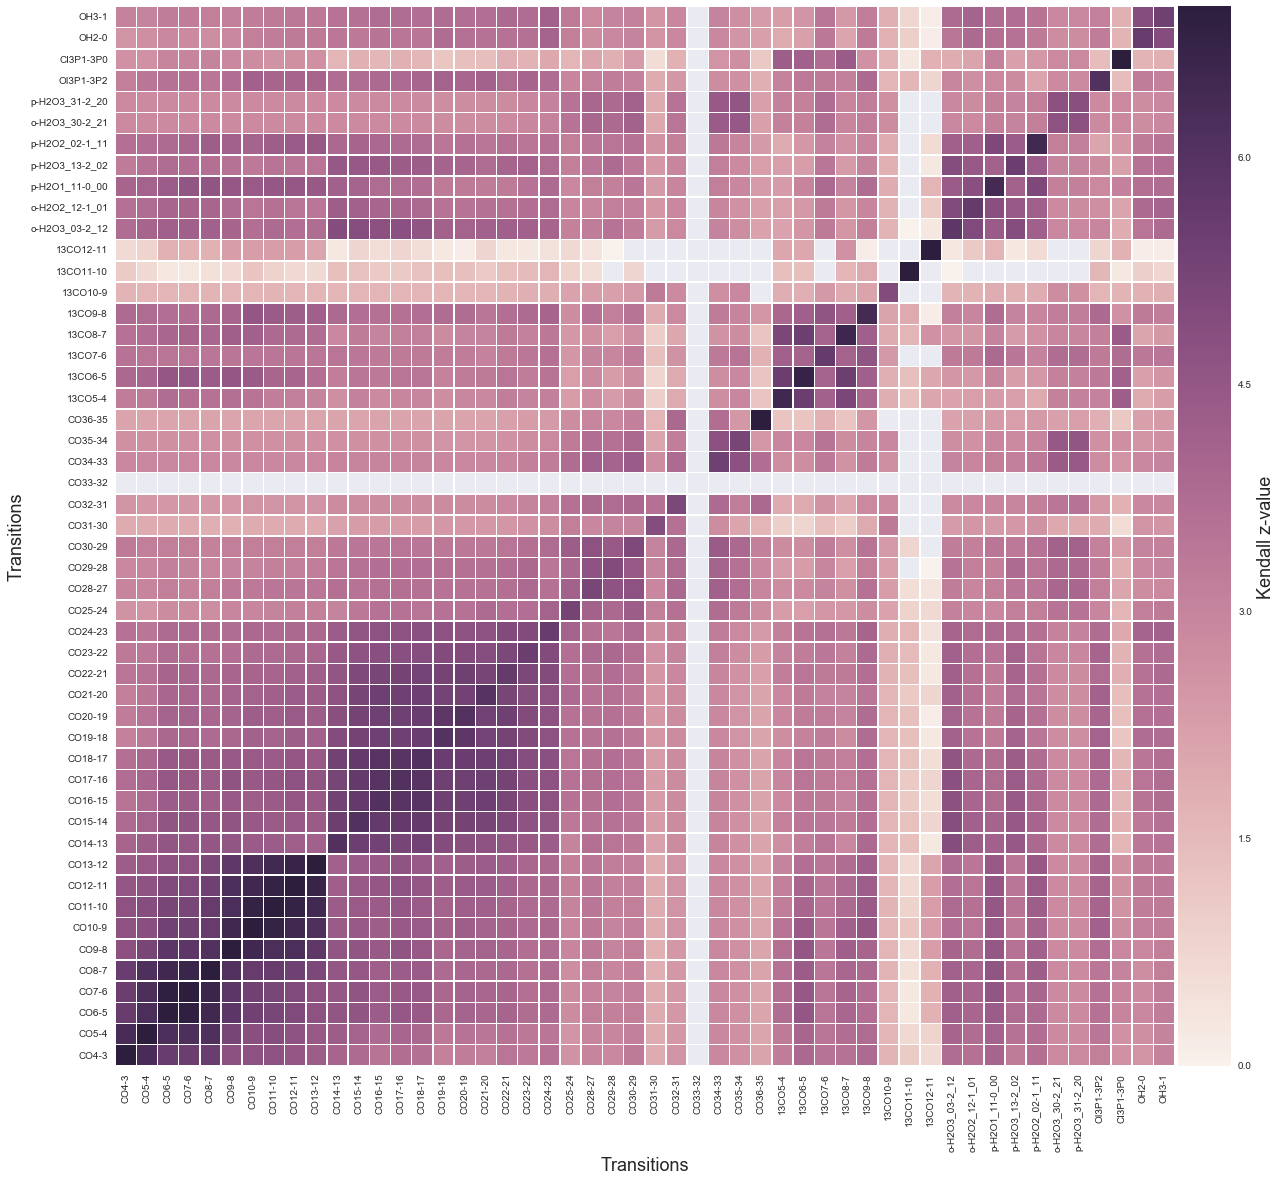

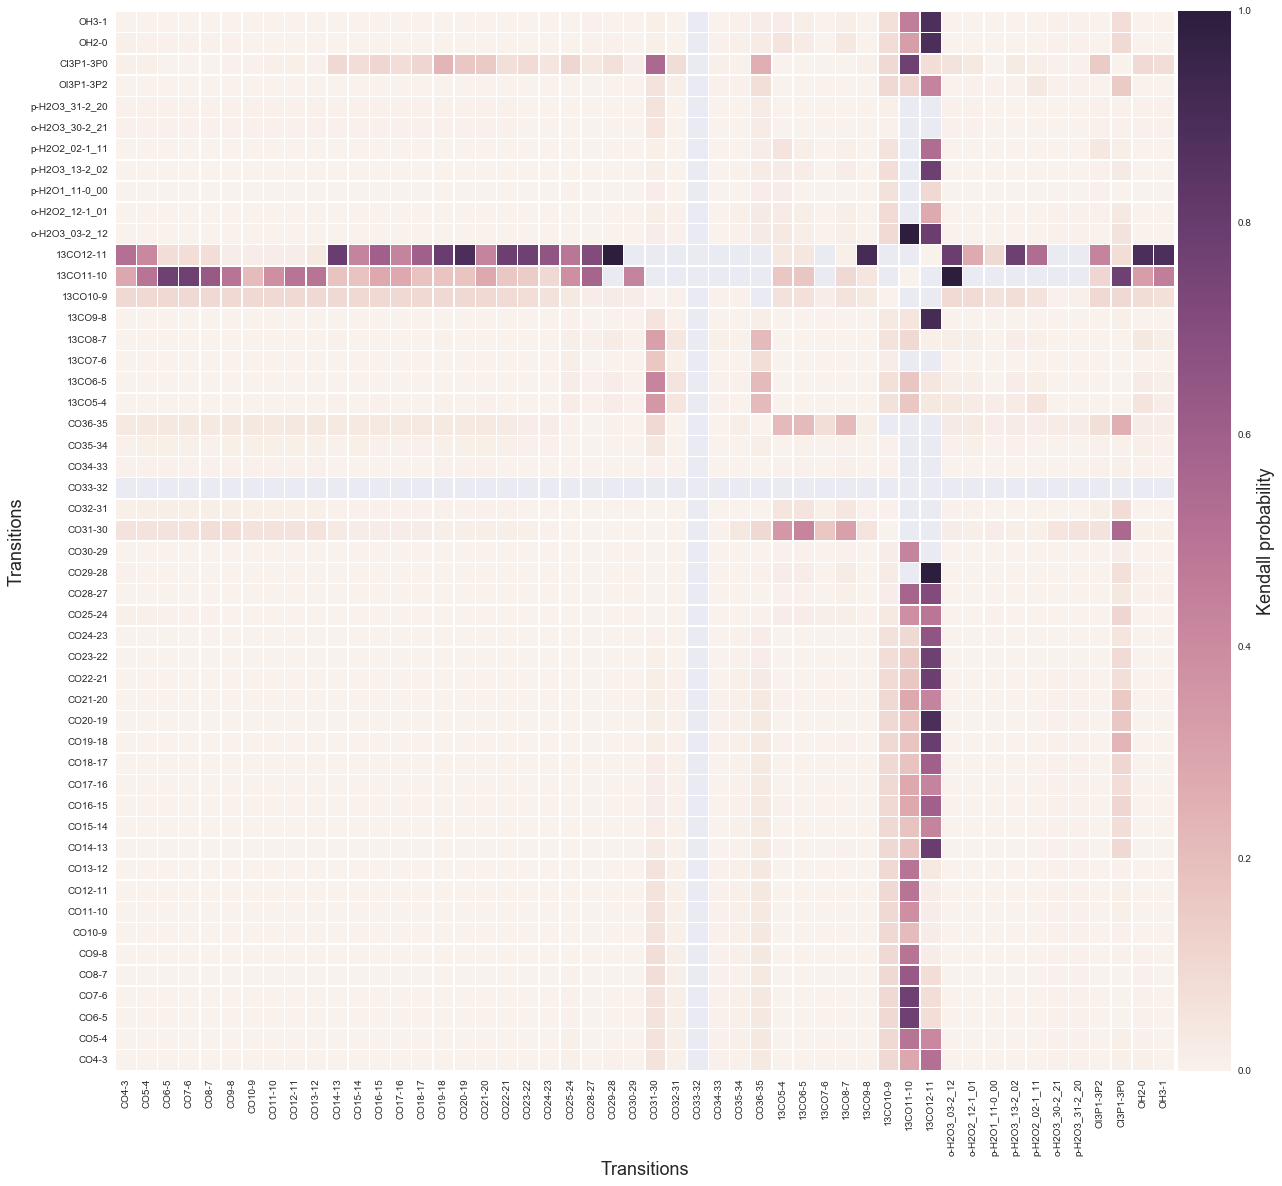

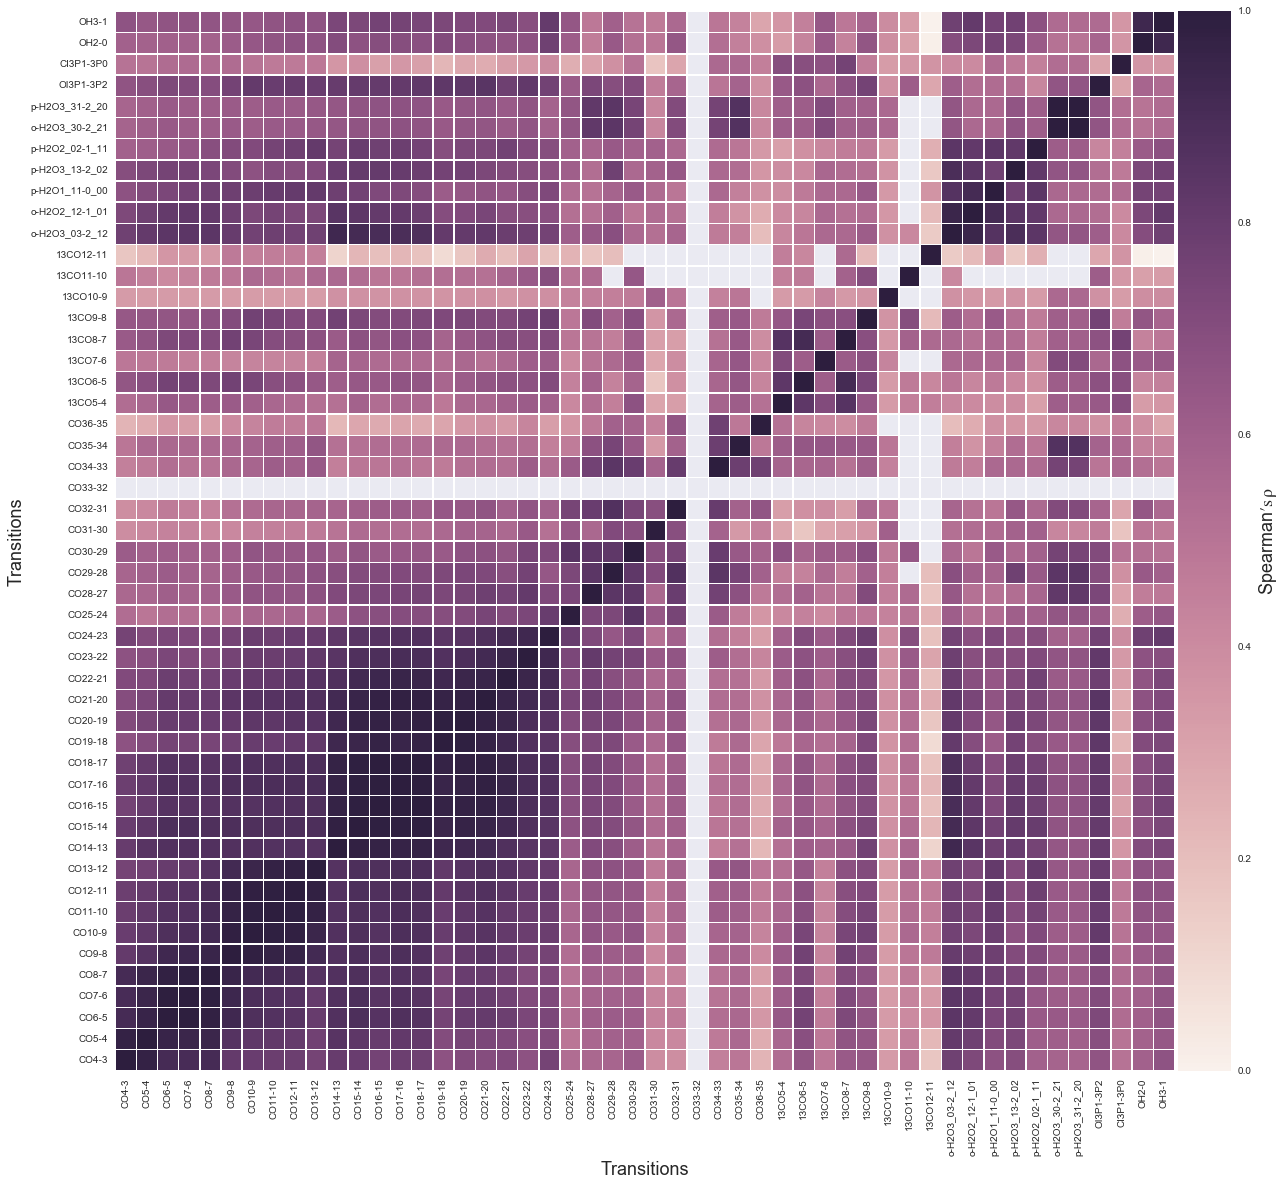

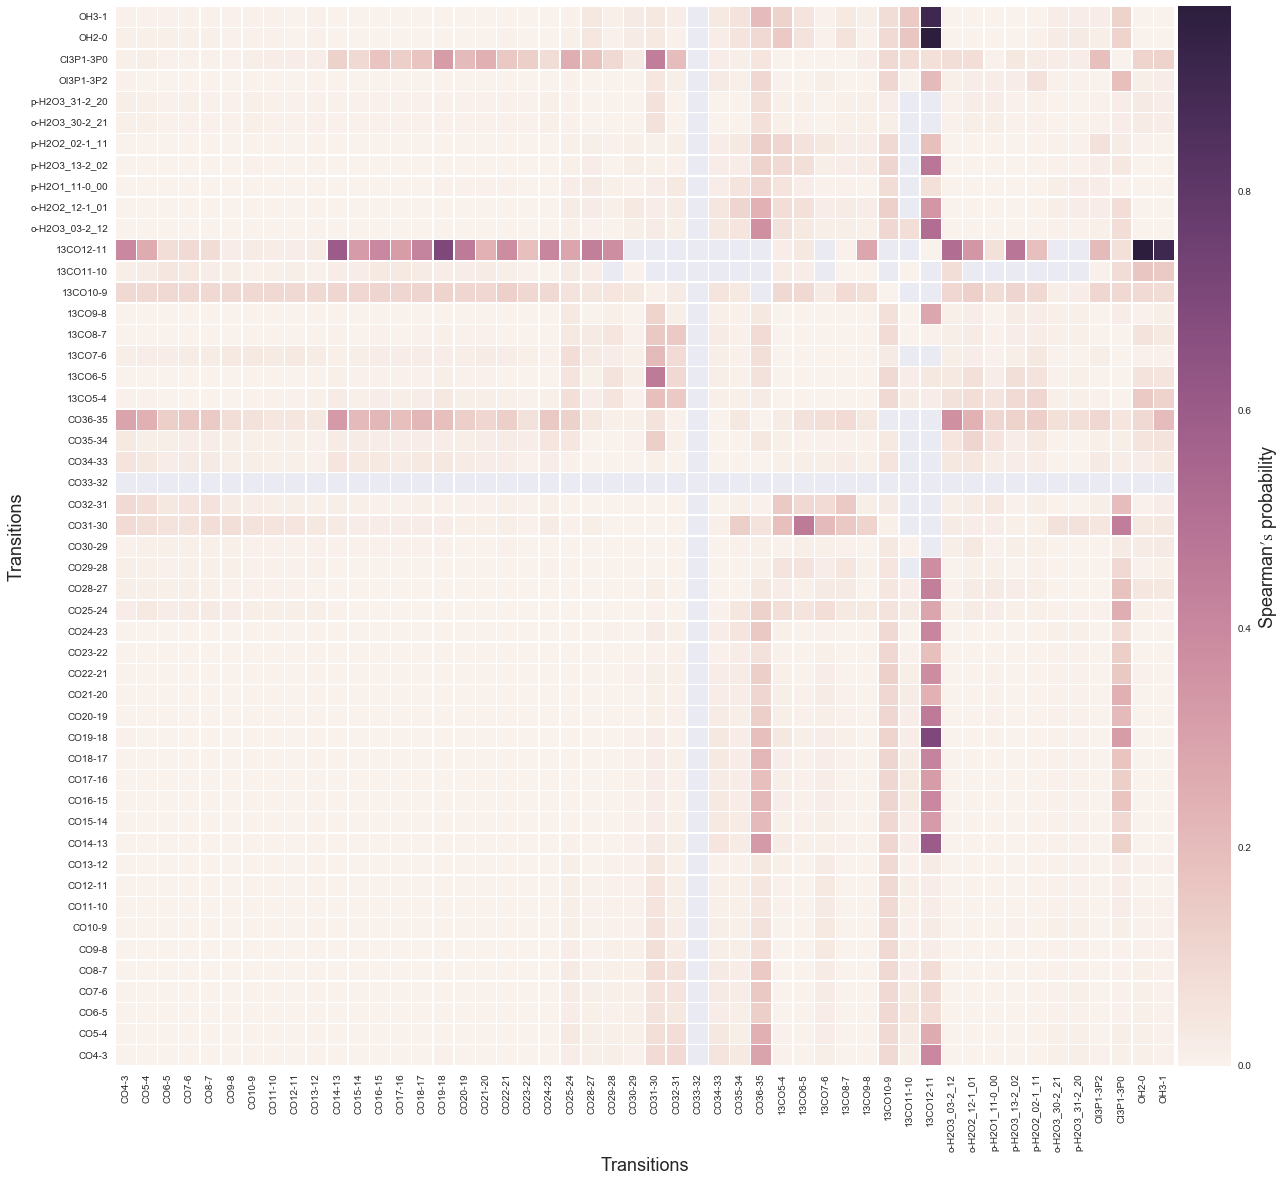

In [40]:
def general_heatmap(line_list, col_name, fitting_table, label):
    import pandas as pd
    import seaborn as sns
    import numpy as np
    from astropy.io import ascii
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable


    # read in the result
    table = ascii.read(outdir+'all_correlation.txt')

    data = np.empty((len(line_list), len(line_list)))
    
    for i in range(len(line_list)):
        for j in range(i, len(line_list)):
            selector1 = (table['Line1'] == line_list[i]) & \
                        (table['Line2'] == line_list[j])
            selector2 = (table['Line2'] == line_list[i]) & \
                        (table['Line1'] == line_list[j])
            selector = selector1 + selector2
            
#             print(line_list[i], line_list[j])
#             print(selector1[selector1 == True], selector2[selector2 == True])
            
            if not (table['Ken.z']+table['Ken.prob']+table['Spr.rho']+table['Spr.prob'])[selector] == 0:
                data[i,j] = table[col_name][selector]
                data[j,i] = table[col_name][selector]
            else:
                data[i,j] = np.nan
                data[j,i] = np.nan


    # construct Pandas DataFrame
    data = data[::-1,:]
    # dataset = pd.DataFrame(data=data[0:5:,-5:], index=j_up[::-1], columns=j_up)
    dataset = pd.DataFrame(data=data, index=line_list[::-1], columns=line_list)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    if col_name == 'Ken.z':
        vmax = 7.0
    else:
        vmax = None
    
    sns.heatmap(dataset, annot=False, linewidths=.5, square=True, ax=ax, cbar_ax=cax, vmax=vmax,
                vmin=0)
    cax.set_ylabel(label, fontsize=18)

    ax.set_xlabel('Transitions', fontsize=18)
    ax.set_ylabel('Transitions', fontsize=18)

    fig.savefig('/Users/yaolun/test/general_heatmap_'+col_name+'.pdf', format='pdf', dpi=300, bbox_inches='tight')

from astropy.io import ascii
import numpy as np                  

col_name = ['Ken.z','Ken.prob','Spr.rho','Spr.prob']
diag_value = [np.nan,0,1,0]
labels = ['Kendall z-value','Kendall probability',r'Spearman$\prime s\,\rho$',r'Spearman$\prime s$ probability']
outdir = '/Users/yaolun/astro_tools/'
corr_table = outdir+'all_correlation.txt'

fitting_table = '/Volumes/SD-Mac/CDF_archive_v2_lines.txt'
# fitting_table = '/Users/yaolun/data/CDF_archive_v2/CDF_archive_v2_lines.txt'
data = ascii.read(fitting_table)['Line'].data
co_list = np.sort(list(set(list(filter(lambda k: k.startswith('CO'), data)))))
j_up = np.sort([int(s.split('CO')[1].split('-')[0]) for s in co_list])  
line_list = ['CO'+str(j_up[i])+'-'+str(j_up[i]-1) for i in range(len(j_up[j_up <= 36]))]
line_list = np.hstack((np.array(line_list),np.array(['13CO5-4','13CO6-5','13CO7-6','13CO8-7','13CO9-8',
                                                     '13CO10-9','13CO11-10','13CO12-11','o-H2O3_03-2_12',
                                                     'o-H2O2_12-1_01','p-H2O1_11-0_00',
                                                     'p-H2O3_13-2_02','p-H2O2_02-1_11',
                                                     'o-H2O3_30-2_21','p-H2O3_31-2_20',
                                                     'OI3P1-3P2','CI3P1-3P0',
                                                     'OH2-0','OH3-1'])))
# '13CO13-12', 'o-H2O3_21-1_10' no detection
# general_heatmap(line_list, col_name[2], corr_table, labels[2])

for i in range(len(col_name)):
    general_heatmap(line_list, col_name[i], corr_table, labels[i])